In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

### DATA
pbot  --->  sum(bottom photomultipliers)

ptop  --->  sum(top photomultipliers)


ppeakS1 --> variables of S1 peak

ppeakS2 --> variables of S2 peak
    
        variables: pT0    -> absolute initial time of the pulse
                    pA    -> total integrated area of the pulse
                    pH    -> pulse maximum amplitude
                    pHT   -> time at which the pulse has max amplitude (from pT0)
                    pL    -> time length of the pulse
                    pL90  -> time length with 90% area of the pulse (from 5-95% integrated area)
                    pRMSW -> pulse root mean square (RMS) width
                    pHTL  -> ratio between pHT and pL

In [4]:
mDM = 500

filefolder = '../data2024/processed/'

In [5]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


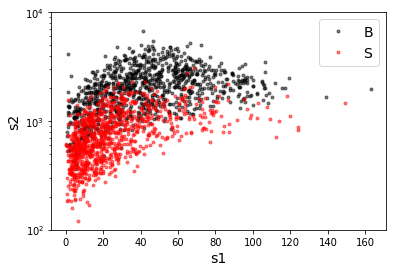

In [6]:

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the zeros (no S1 and S2 signal at the same time)

In [7]:
# boolean mask, array with True or False: if there is a zero -> False, if there is a value != 0 -> True
B_mask = B_pbot != 0

# apply the mask
B_pbot = B_pbot[B_mask]
B_ptop = B_ptop[B_mask]
B_ppeakS1 = B_ppeakS1[B_mask]
B_ppeakS2 = B_ppeakS2[B_mask]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



# boolean mask, array with True or False: if there is a zero -> False, if there is a value != 0 -> True
S_mask = S_pbot != 0

# apply the mask
S_pbot = S_pbot[S_mask]
S_ptop = S_ptop[S_mask]
S_ppeakS1 = S_ppeakS1[S_mask]
S_ppeakS2 = S_ppeakS2[S_mask]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


##### Select the number of events per class

In [8]:
NUM_DAT = min(len(B_pbot), len(S_pbot))
print(' NUM_DAT: ', NUM_DAT, '\n')

B_pbot = B_pbot[:NUM_DAT]
B_ptop = B_ptop[:NUM_DAT]
B_ppeakS1 = B_ppeakS1[:NUM_DAT]
B_ppeakS2 = B_ppeakS2[:NUM_DAT]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:NUM_DAT]
S_ptop = S_ptop[:NUM_DAT]
S_ppeakS1 = S_ppeakS1[:NUM_DAT]
S_ppeakS2 = S_ppeakS2[:NUM_DAT]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

 NUM_DAT:  32015 

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 8)
B_ppeakS2.shape:  (32015, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


###### Construct time diff between pulses

B_pdiffT.shape:  (32015,)
S_pdiffT.shape:  (32015,)


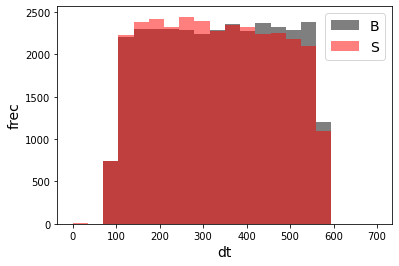

In [9]:
B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove some columns or features (if you want)

In [10]:
remove_col = [0]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 7)
B_ppeakS2.shape:  (32015, 7)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 7)
S_ppeakS2.shape:  (32015, 7)


In [38]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 17)
X_mon_S.shape:  (32015, 17)
X_mon.shape:  (64030, 17)

X_mon_train :  (40818, 17)
y_mon_train :  (40818,)
X_mon_val :  (7204, 17)
y_mon_val :  (7204,)
X_mon_test :  (16008, 17)
y_mon_test :  (16008,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.62914	validation_1-logloss:0.62988
[1]	validation_0-logloss:0.57610	validation_1-logloss:0.57703
[2]	validation_0-logloss:0.53104	validation_1-logloss:0.53279


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-logloss:0.49230	validation_1-logloss:0.49445
[4]	validation_0-logloss:0.45930	validation_1-logloss:0.46154
[5]	validation_0-logloss:0.43018	validation_1-logloss:0.43295
[6]	validation_0-logloss:0.40461	validation_1-logloss:0.40784
[7]	validation_0-logloss:0.38219	validation_1-logloss:0.38522
[8]	validation_0-logloss:0.36221	validation_1-logloss:0.36538
[9]	validation_0-logloss:0.34404	validation_1-logloss:0.34787
[10]	validation_0-logloss:0.32791	validation_1-logloss:0.33233
[11]	validation_0-logloss:0.31368	validation_1-logloss:0.31800
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30542
[13]	validation_0-logloss:0.28939	validation_1-logloss:0.29474
[14]	validation_0-logloss:0.27886	validation_1-logloss:0.28453
[15]	validation_0-logloss:0.26960	validation_1-logloss:0.27559
[16]	validation_0-logloss:0.26119	validation_1-logloss:0.26775
[17]	validation_0-logloss:0.25335	validation_1-logloss:0.26003
[18]	validation_0-logloss:0.24605	validation_1-logloss:0.25315

[133]	validation_0-logloss:0.13751	validation_1-logloss:0.17367
[134]	validation_0-logloss:0.13738	validation_1-logloss:0.17368
[135]	validation_0-logloss:0.13715	validation_1-logloss:0.17369
[136]	validation_0-logloss:0.13684	validation_1-logloss:0.17370
[137]	validation_0-logloss:0.13663	validation_1-logloss:0.17374
[138]	validation_0-logloss:0.13632	validation_1-logloss:0.17358
[139]	validation_0-logloss:0.13611	validation_1-logloss:0.17358
[140]	validation_0-logloss:0.13594	validation_1-logloss:0.17357
[141]	validation_0-logloss:0.13581	validation_1-logloss:0.17358
[142]	validation_0-logloss:0.13550	validation_1-logloss:0.17367
[143]	validation_0-logloss:0.13540	validation_1-logloss:0.17365
[144]	validation_0-logloss:0.13512	validation_1-logloss:0.17367
[145]	validation_0-logloss:0.13496	validation_1-logloss:0.17374
[146]	validation_0-logloss:0.13490	validation_1-logloss:0.17373
[147]	validation_0-logloss:0.13471	validation_1-logloss:0.17372
[148]	validation_0-logloss:0.13458	valid

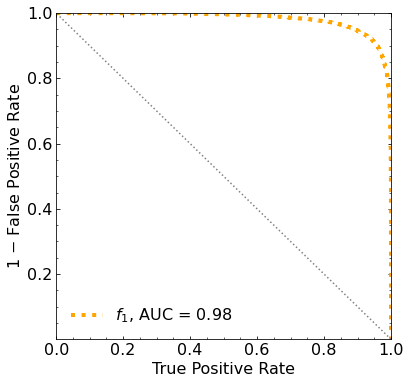

Classification score:


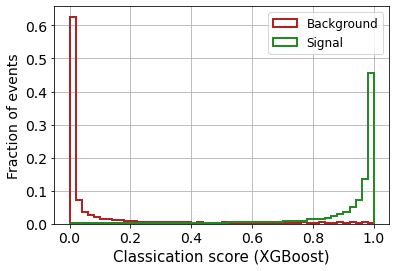


 ROC-AUC =  0.9810425521542311


In [39]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

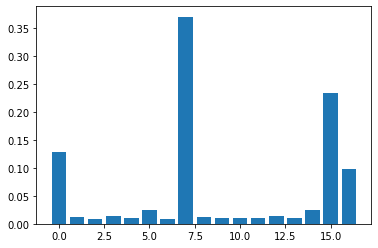

In [40]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

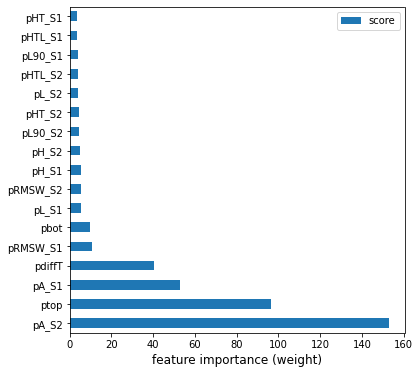

In [41]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [15]:
keys

['pA_S1',
 'pH_S1',
 'pHT_S1',
 'pL_S1',
 'pL90_S1',
 'pRMSW_S1',
 'pHTL_S1',
 'pA_S2',
 'pH_S2',
 'pHT_S2',
 'pL_S2',
 'pL90_S2',
 'pRMSW_S2',
 'pHTL_S2',
 'pbot',
 'ptop',
 'pdiffT']

In [16]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [39]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['pHT_S1',
 'pHTL_S1',
 'pL90_S1',
 'pHTL_S2',
 'pL_S2',
 'pHT_S2',
 'pL90_S2',
 'pH_S2',
 'pH_S1',
 'pRMSW_S2',
 'pL_S1',
 'pbot',
 'pRMSW_S1',
 'pdiffT',
 'pA_S1',
 'ptop',
 'pA_S2']

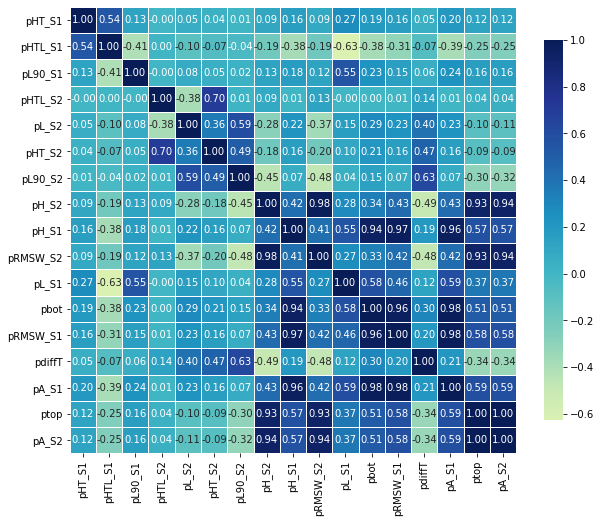

In [40]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

Epoch 106/500
319/319 [==============================] - 0s 1ms/step - loss: 0.2901 - accuracy: 0.8841 - val_loss: 0.2903 - val_accuracy: 0.8749
Epoch 107/500
319/319 [==============================] - 1s 2ms/step - loss: 0.2932 - accuracy: 0.8850 - val_loss: 0.2752 - val_accuracy: 0.8831
Epoch 108/500
319/319 [==============================] - 0s 1ms/step - loss: 0.2883 - accuracy: 0.8874 - val_loss: 0.2511 - val_accuracy: 0.8969
Epoch 109/500
319/319 [==============================] - 1s 2ms/step - loss: 0.2874 - accuracy: 0.8862 - val_loss: 0.3014 - val_accuracy: 0.8691
Epoch 110/500
319/319 [==============================] - 0s 1ms/step - loss: 0.2862 - accuracy: 0.8887 - val_loss: 0.2785 - val_accuracy: 0.8817
Epoch 111/500
319/319 [==============================] - 1s 2ms/step - loss: 0.2861 - accuracy: 0.8877 - val_loss: 0.2756 - val_accuracy: 0.8824
Epoch 112/500
319/319 [==============================] - 0s 1ms/step - loss: 0.2808 - accuracy: 0.8926 - val_loss: 0.2815 - val_ac

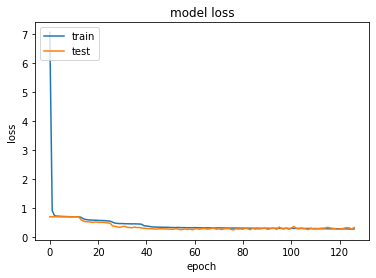

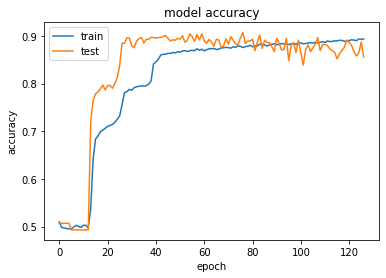

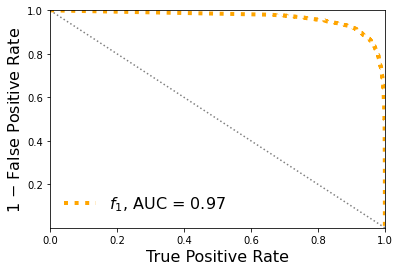

Classification score:


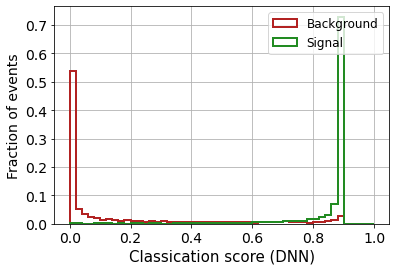


 ROC-AUC =  0.9677028413669444


In [16]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [38]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
122/122 [==============================] - 1s 4ms/step - loss: 8.8190 - accuracy: 0.4946 - val_loss: 0.6357 - val_accuracy: 0.5158
Epoch 2/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.5921 - val_loss: 0.6303 - val_accuracy: 0.6318
Epoch 3/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.6248 - val_loss: 0.6350 - val_accuracy: 0.6187
Epoch 4/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.6264 - val_loss: 0.6165 - val_accuracy: 0.6434
Epoch 5/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.6315 - val_loss: 0.6123 - val_accuracy: 0.6514
Epoch 6/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6330 - val_loss: 0.6049 - val_accuracy: 0.6627
Epoch 7/500
122/122 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.6434 - val_loss: 0.6019 - val_accuracy: 0.6648

Epoch 58/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4213 - accuracy: 0.8264 - val_loss: 0.3336 - val_accuracy: 0.8924
Epoch 59/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.8099 - val_loss: 0.3099 - val_accuracy: 0.8975
Epoch 60/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8263 - val_loss: 0.3089 - val_accuracy: 0.9062
Epoch 61/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4397 - accuracy: 0.8118 - val_loss: 0.3132 - val_accuracy: 0.9037
Epoch 62/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8215 - val_loss: 0.3059 - val_accuracy: 0.9069
Epoch 63/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4174 - accuracy: 0.8283 - val_loss: 0.3022 - val_accuracy: 0.9113
Epoch 64/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8305 - val_loss: 0.2995 - val_accuracy:

Epoch 115/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8351 - val_loss: 0.2965 - val_accuracy: 0.9106
Epoch 116/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3997 - accuracy: 0.8389 - val_loss: 0.2907 - val_accuracy: 0.9149
Epoch 117/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8277 - val_loss: 0.2843 - val_accuracy: 0.9204
Epoch 118/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8360 - val_loss: 0.2777 - val_accuracy: 0.9233
Epoch 119/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8261 - val_loss: 0.2886 - val_accuracy: 0.9200
Epoch 120/500
122/122 [==============================] - 0s 3ms/step - loss: 0.4083 - accuracy: 0.8343 - val_loss: 0.2825 - val_accuracy: 0.9248
Epoch 121/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8317 - val_loss: 0.2812 - val_ac

122/122 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.8381 - val_loss: 0.3306 - val_accuracy: 0.8753
Epoch 228/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3962 - accuracy: 0.8406 - val_loss: 0.2736 - val_accuracy: 0.9237
Epoch 229/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4127 - accuracy: 0.8299 - val_loss: 0.2817 - val_accuracy: 0.9186
Epoch 230/500
122/122 [==============================] - 0s 3ms/step - loss: 0.3986 - accuracy: 0.8383 - val_loss: 0.2855 - val_accuracy: 0.9160
Epoch 231/500
122/122 [==============================] - 0s 3ms/step - loss: 0.3975 - accuracy: 0.8399 - val_loss: 0.2719 - val_accuracy: 0.9237
Epoch 232/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.8398 - val_loss: 0.2825 - val_accuracy: 0.9120
Epoch 233/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8405 - val_loss: 0.2879 - val_accuracy: 0.9106

122/122 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8418 - val_loss: 0.2820 - val_accuracy: 0.9175
Epoch 340/500
122/122 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8381 - val_loss: 0.2740 - val_accuracy: 0.9237
Epoch 341/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.8465 - val_loss: 0.2698 - val_accuracy: 0.9237
Epoch 342/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.8481 - val_loss: 0.2922 - val_accuracy: 0.9040
Epoch 343/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3959 - accuracy: 0.8406 - val_loss: 0.2724 - val_accuracy: 0.9233
Epoch 344/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8388 - val_loss: 0.2678 - val_accuracy: 0.9222
Epoch 345/500
122/122 [==============================] - 0s 2ms/step - loss: 0.3998 - accuracy: 0.8366 - val_loss: 0.2716 - val_accuracy: 0.9237

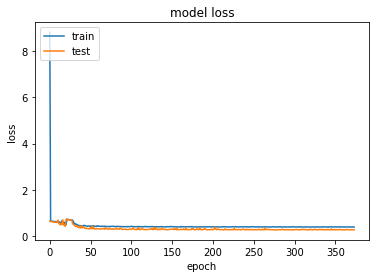

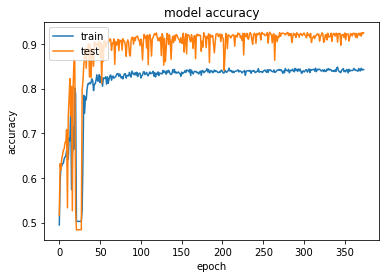

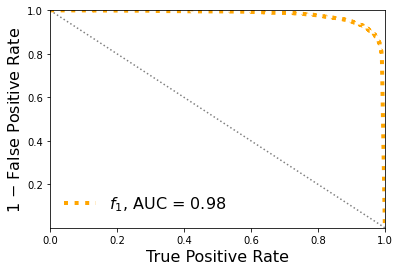

Classification score:


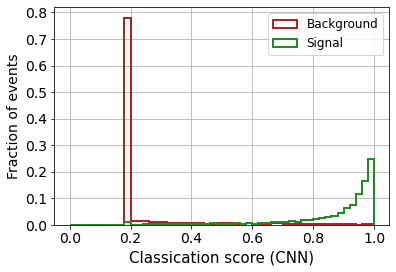


 ROC-AUC =  0.9783652425787722


In [39]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

### Remove time diff between pulses

In [11]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 16)
X_mon_S.shape:  (32015, 16)
X_mon.shape:  (64030, 16)

X_mon_train :  (40818, 16)
y_mon_train :  (40818,)
X_mon_val :  (7204, 16)
y_mon_val :  (7204,)
X_mon_test :  (16008, 16)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.63784	validation_1-logloss:0.63749
[1]	validation_0-logloss:0.59159	validation_1-logloss:0.59123
[2]	validation_0-logloss:0.55291	validation_1-logloss:0.55243
[3]	validation_0-logloss:0.51994	validation_1-logloss:0.51958


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.49159	validation_1-logloss:0.49126
[5]	validation_0-logloss:0.46657	validation_1-logloss:0.46659
[6]	validation_0-logloss:0.44508	validation_1-logloss:0.44551
[7]	validation_0-logloss:0.42634	validation_1-logloss:0.42675
[8]	validation_0-logloss:0.40997	validation_1-logloss:0.41075
[9]	validation_0-logloss:0.39521	validation_1-logloss:0.39619
[10]	validation_0-logloss:0.38241	validation_1-logloss:0.38358
[11]	validation_0-logloss:0.37101	validation_1-logloss:0.37252
[12]	validation_0-logloss:0.36034	validation_1-logloss:0.36224
[13]	validation_0-logloss:0.35124	validation_1-logloss:0.35322
[14]	validation_0-logloss:0.34306	validation_1-logloss:0.34550
[15]	validation_0-logloss:0.33585	validation_1-logloss:0.33850
[16]	validation_0-logloss:0.32922	validation_1-logloss:0.33232
[17]	validation_0-logloss:0.32305	validation_1-logloss:0.32658
[18]	validation_0-logloss:0.31740	validation_1-logloss:0.32171
[19]	validation_0-logloss:0.31239	validation_1-logloss:0.3172

[134]	validation_0-logloss:0.21178	validation_1-logloss:0.25432
[135]	validation_0-logloss:0.21159	validation_1-logloss:0.25437
[136]	validation_0-logloss:0.21141	validation_1-logloss:0.25432
[137]	validation_0-logloss:0.21111	validation_1-logloss:0.25413
[138]	validation_0-logloss:0.21085	validation_1-logloss:0.25400
[139]	validation_0-logloss:0.21053	validation_1-logloss:0.25390
[140]	validation_0-logloss:0.21011	validation_1-logloss:0.25373
[141]	validation_0-logloss:0.20975	validation_1-logloss:0.25371
[142]	validation_0-logloss:0.20949	validation_1-logloss:0.25371
[143]	validation_0-logloss:0.20921	validation_1-logloss:0.25381
[144]	validation_0-logloss:0.20890	validation_1-logloss:0.25367
[145]	validation_0-logloss:0.20866	validation_1-logloss:0.25359
[146]	validation_0-logloss:0.20833	validation_1-logloss:0.25362
[147]	validation_0-logloss:0.20800	validation_1-logloss:0.25357
[148]	validation_0-logloss:0.20753	validation_1-logloss:0.25350
[149]	validation_0-logloss:0.20719	valid

[263]	validation_0-logloss:0.17835	validation_1-logloss:0.25126
[264]	validation_0-logloss:0.17808	validation_1-logloss:0.25115
[265]	validation_0-logloss:0.17787	validation_1-logloss:0.25115
[266]	validation_0-logloss:0.17767	validation_1-logloss:0.25118
[267]	validation_0-logloss:0.17747	validation_1-logloss:0.25136
[268]	validation_0-logloss:0.17734	validation_1-logloss:0.25146
[269]	validation_0-logloss:0.17713	validation_1-logloss:0.25146
[270]	validation_0-logloss:0.17712	validation_1-logloss:0.25147
[271]	validation_0-logloss:0.17688	validation_1-logloss:0.25148
[272]	validation_0-logloss:0.17670	validation_1-logloss:0.25158
[273]	validation_0-logloss:0.17639	validation_1-logloss:0.25166
[274]	validation_0-logloss:0.17617	validation_1-logloss:0.25159
[275]	validation_0-logloss:0.17608	validation_1-logloss:0.25156
[276]	validation_0-logloss:0.17597	validation_1-logloss:0.25166
[277]	validation_0-logloss:0.17576	validation_1-logloss:0.25167
[278]	validation_0-logloss:0.17565	valid

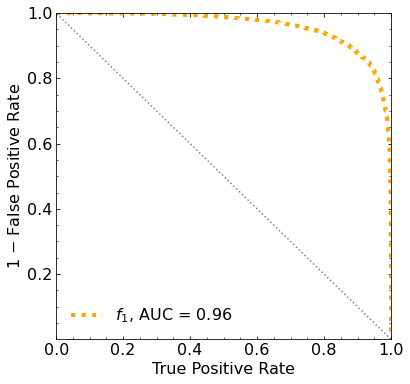

Classification score:


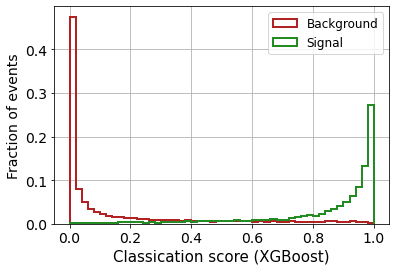


 ROC-AUC =  0.9593169670949507


In [43]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

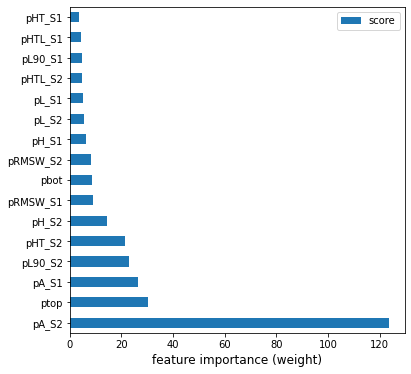

In [44]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

319/319 [==============================] - 1s 2ms/step - loss: 0.4104 - accuracy: 0.7814 - val_loss: 0.3169 - val_accuracy: 0.8766
Epoch 50/500
319/319 [==============================] - 0s 1ms/step - loss: 0.4119 - accuracy: 0.7834 - val_loss: 0.3150 - val_accuracy: 0.8726
Epoch 51/500
319/319 [==============================] - 0s 1ms/step - loss: 0.4077 - accuracy: 0.7800 - val_loss: 0.3213 - val_accuracy: 0.8733
Epoch 52/500
319/319 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.7812 - val_loss: 0.3047 - val_accuracy: 0.8759
Epoch 53/500
319/319 [==============================] - 0s 1ms/step - loss: 0.4061 - accuracy: 0.7869 - val_loss: 0.3230 - val_accuracy: 0.8783
Epoch 54/500
319/319 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 0.7813 - val_loss: 0.3133 - val_accuracy: 0.8765
Epoch 55/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3991 - accuracy: 0.7893 - val_loss: 0.3229 - val_accuracy: 0.8772
Epoch

Epoch 106/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3374 - accuracy: 0.8587 - val_loss: 0.2871 - val_accuracy: 0.8769
Epoch 107/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3360 - accuracy: 0.8600 - val_loss: 0.2890 - val_accuracy: 0.8794
Epoch 108/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3342 - accuracy: 0.8614 - val_loss: 0.2928 - val_accuracy: 0.8753
Epoch 109/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3337 - accuracy: 0.8584 - val_loss: 0.2959 - val_accuracy: 0.8701
Epoch 110/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.8609 - val_loss: 0.2933 - val_accuracy: 0.8734
Epoch 111/500
319/319 [==============================] - 0s 995us/step - loss: 0.3323 - accuracy: 0.8597 - val_loss: 0.2864 - val_accuracy: 0.8795
Epoch 112/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8618 - val_loss: 0.2868 - val_

319/319 [==============================] - 1s 2ms/step - loss: 0.3290 - accuracy: 0.8666 - val_loss: 0.2999 - val_accuracy: 0.8674
Epoch 219/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3269 - accuracy: 0.8634 - val_loss: 0.2849 - val_accuracy: 0.8785
Epoch 220/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3285 - accuracy: 0.8625 - val_loss: 0.2836 - val_accuracy: 0.8784
Epoch 221/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3273 - accuracy: 0.8637 - val_loss: 0.2891 - val_accuracy: 0.8756
Epoch 222/500
319/319 [==============================] - 0s 2ms/step - loss: 0.3287 - accuracy: 0.8644 - val_loss: 0.2838 - val_accuracy: 0.8781
Epoch 223/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3310 - accuracy: 0.8628 - val_loss: 0.2880 - val_accuracy: 0.8752
Epoch 224/500
319/319 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.8651 - val_loss: 0.2868 - val_accuracy: 0.8752

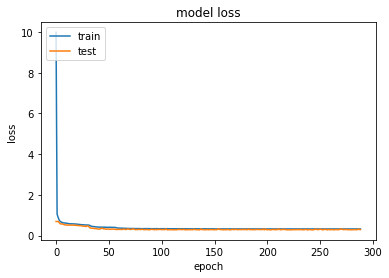

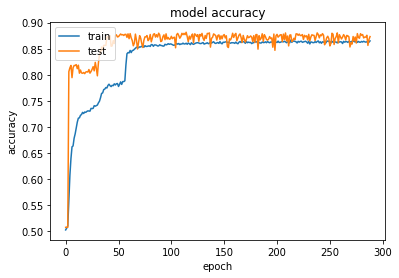

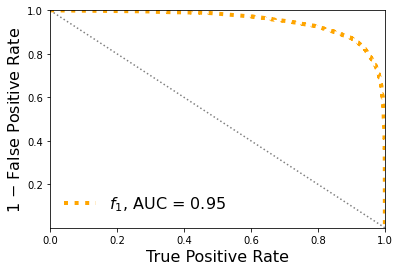

Classification score:


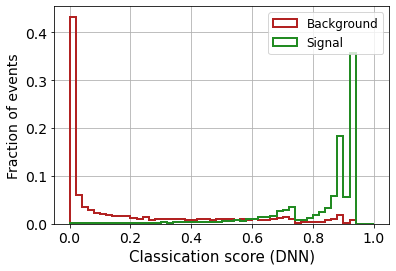


 ROC-AUC =  0.9525922139894779


In [20]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [12]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 10s 2ms/step - loss: 56.4224 - accuracy: 0.5203 - val_loss: 0.6589 - val_accuracy: 0.5075
Epoch 2/500
319/319 [==============================] - 0s 849us/step - loss: 0.6548 - accuracy: 0.6039 - val_loss: 0.5759 - val_accuracy: 0.8091
Epoch 3/500
319/319 [==============================] - 0s 842us/step - loss: 0.5954 - accuracy: 0.7318 - val_loss: 0.5161 - val_accuracy: 0.8220
Epoch 4/500
319/319 [==============================] - 0s 814us/step - loss: 0.5621 - accuracy: 0.7444 - val_loss: 0.4921 - val_accuracy: 0.8222
Epoch 5/500
319/319 [==============================] - 0s 823us/step - loss: 0.5465 - accuracy: 0.7509 - val_loss: 0.4550 - val_accuracy: 0.8466
Epoch 6/500
319/319 [==============================] - 0s 835us/step - loss: 0.5284 - accuracy: 0.7614 - val_loss: 0.4645 - val_accuracy: 0.8312
Epoch 7/500
319/319 [==============================] - 0s 829us/step - loss: 0.5126 - accuracy: 0.7706 - val_loss: 0.4380 - val_ac

319/319 [==============================] - 0s 809us/step - loss: 0.4653 - accuracy: 0.7989 - val_loss: 0.3625 - val_accuracy: 0.8712
Epoch 58/500
319/319 [==============================] - 0s 812us/step - loss: 0.4705 - accuracy: 0.7966 - val_loss: 0.3471 - val_accuracy: 0.8896
Epoch 59/500
319/319 [==============================] - 0s 834us/step - loss: 0.4589 - accuracy: 0.8039 - val_loss: 0.3468 - val_accuracy: 0.8870
Epoch 60/500
319/319 [==============================] - 0s 834us/step - loss: 0.4652 - accuracy: 0.7986 - val_loss: 0.3503 - val_accuracy: 0.8863
Epoch 61/500
319/319 [==============================] - 0s 832us/step - loss: 0.4563 - accuracy: 0.8049 - val_loss: 0.3474 - val_accuracy: 0.8880
Epoch 62/500
319/319 [==============================] - 0s 832us/step - loss: 0.4599 - accuracy: 0.8027 - val_loss: 0.3892 - val_accuracy: 0.8567
Epoch 63/500
319/319 [==============================] - 0s 847us/step - loss: 0.4533 - accuracy: 0.8083 - val_loss: 0.3439 - val_accuracy

319/319 [==============================] - 0s 819us/step - loss: 0.4539 - accuracy: 0.8063 - val_loss: 0.3667 - val_accuracy: 0.8740
Epoch 114/500
319/319 [==============================] - 0s 811us/step - loss: 0.4567 - accuracy: 0.8039 - val_loss: 0.3395 - val_accuracy: 0.8898
Epoch 115/500
319/319 [==============================] - 0s 816us/step - loss: 0.4500 - accuracy: 0.8094 - val_loss: 0.3608 - val_accuracy: 0.8778
Epoch 116/500
319/319 [==============================] - 0s 807us/step - loss: 0.4502 - accuracy: 0.8087 - val_loss: 0.3570 - val_accuracy: 0.8801
Epoch 117/500
319/319 [==============================] - 0s 818us/step - loss: 0.4538 - accuracy: 0.8058 - val_loss: 0.3456 - val_accuracy: 0.8888
Epoch 118/500
319/319 [==============================] - 0s 831us/step - loss: 0.4633 - accuracy: 0.7975 - val_loss: 0.3506 - val_accuracy: 0.8865
Epoch 119/500
319/319 [==============================] - 0s 828us/step - loss: 0.4486 - accuracy: 0.8082 - val_loss: 0.3904 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 839us/step - loss: 0.4470 - accuracy: 0.8110 - val_loss: 0.3367 - val_accuracy: 0.8887
Epoch 170/500
319/319 [==============================] - 0s 832us/step - loss: 0.4530 - accuracy: 0.8075 - val_loss: 0.3447 - val_accuracy: 0.8860
Epoch 171/500
319/319 [==============================] - 0s 832us/step - loss: 0.4489 - accuracy: 0.8078 - val_loss: 0.3530 - val_accuracy: 0.8816
Epoch 172/500
319/319 [==============================] - 0s 837us/step - loss: 0.4441 - accuracy: 0.8128 - val_loss: 0.3476 - val_accuracy: 0.8867
Epoch 173/500
319/319 [==============================] - 0s 834us/step - loss: 0.4525 - accuracy: 0.8060 - val_loss: 0.3569 - val_accuracy: 0.8777
Epoch 174/500
319/319 [==============================] - 0s 821us/step - loss: 0.4437 - accuracy: 0.8125 - val_loss: 0.3405 - val_accuracy: 0.8890
Epoch 175/500
319/319 [==============================] - 0s 839us/step - loss: 0.4499 - accuracy: 0.8060 - val_loss: 0

Epoch 225/500
319/319 [==============================] - 0s 804us/step - loss: 0.4542 - accuracy: 0.8029 - val_loss: 0.3440 - val_accuracy: 0.8866
Epoch 226/500
319/319 [==============================] - 0s 797us/step - loss: 0.4470 - accuracy: 0.8088 - val_loss: 0.3542 - val_accuracy: 0.8785
Epoch 227/500
319/319 [==============================] - 0s 790us/step - loss: 0.4548 - accuracy: 0.8040 - val_loss: 0.3575 - val_accuracy: 0.8759
Epoch 228/500
319/319 [==============================] - 0s 794us/step - loss: 0.4467 - accuracy: 0.8100 - val_loss: 0.3620 - val_accuracy: 0.8734
Epoch 229/500
319/319 [==============================] - 0s 804us/step - loss: 0.4550 - accuracy: 0.8023 - val_loss: 0.3386 - val_accuracy: 0.8892
Epoch 230/500
319/319 [==============================] - 0s 795us/step - loss: 0.4516 - accuracy: 0.8074 - val_loss: 0.3808 - val_accuracy: 0.8606
Epoch 231/500
319/319 [==============================] - 0s 809us/step - loss: 0.4511 - accuracy: 0.8066 - val_loss: 0

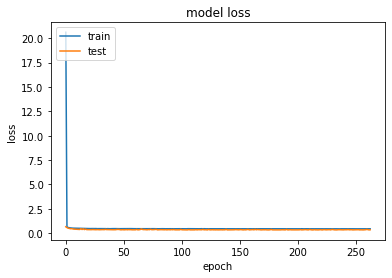

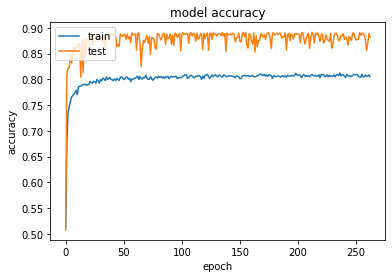

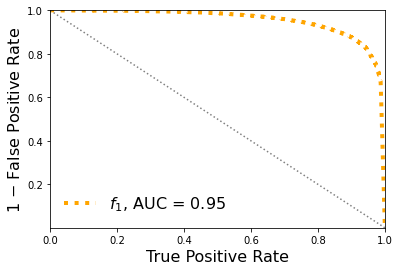

Classification score:


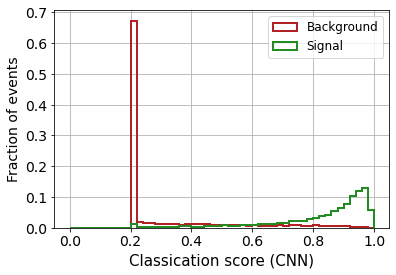


 ROC-AUC =  0.9533128425584826


In [13]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

### Keep 4 variables, pA_S1, pA_S2, ptop, pbot

In [21]:
remove_col = [1,2,3,4,5,6]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 1)
B_ppeakS2.shape:  (32015, 1)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 1)
S_ppeakS2.shape:  (32015, 1)


In [22]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 4)
X_mon_S.shape:  (32015, 4)
X_mon.shape:  (64030, 4)

X_mon_train :  (40818, 4)
y_mon_train :  (40818,)
X_mon_val :  (7204, 4)
y_mon_val :  (7204,)
X_mon_test :  (16008, 4)
y_mon_test :  (16008,)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64317	validation_1-logloss:0.64234
[1]	validation_0-logloss:0.60230	validation_1-logloss:0.60080
[2]	validation_0-logloss:0.56834	validation_1-logloss:0.56639
[3]	validation_0-logloss:0.53937	validation_1-logloss:0.53718
[4]	validation_0-logloss:0.51487	validation_1-logloss:0.51263
[5]	validation_0-logloss:0.49394	validation_1-logloss:0.49134
[6]	validation_0-logloss:0.47616	validation_1-logloss:0.47334
[7]	validation_0-logloss:0.46057	validation_1-logloss:0.45760
[8]	validation_0-logloss:0.44717	validation_1-logloss:0.44419
[9]	validation_0-logloss:0.43539	validation_1-logloss:0.43263
[10]	validation_0-logloss:0.42486	validation_1-logloss:0.42245
[11]	validation_0-logloss:0.41541	validation_1-logloss:0.41324
[12]	validation_0-logloss:0.40758	validation_1-logloss:0.40561
[13]	validation_0-logloss:0.40056	validation_1-logloss:0.39885
[14]	validation_0-logloss:0.39436	validation_1-logloss:0.39309
[15]	validation_0-logloss:0.38870	validation_1-logloss:0.38794
[1

[130]	validation_0-logloss:0.28937	validation_1-logloss:0.31860
[131]	validation_0-logloss:0.28922	validation_1-logloss:0.31856
[132]	validation_0-logloss:0.28881	validation_1-logloss:0.31827
[133]	validation_0-logloss:0.28857	validation_1-logloss:0.31834
[134]	validation_0-logloss:0.28844	validation_1-logloss:0.31831
[135]	validation_0-logloss:0.28821	validation_1-logloss:0.31835
[136]	validation_0-logloss:0.28793	validation_1-logloss:0.31842
[137]	validation_0-logloss:0.28771	validation_1-logloss:0.31828
[138]	validation_0-logloss:0.28747	validation_1-logloss:0.31818
[139]	validation_0-logloss:0.28713	validation_1-logloss:0.31816
[140]	validation_0-logloss:0.28691	validation_1-logloss:0.31815
[141]	validation_0-logloss:0.28654	validation_1-logloss:0.31804
[142]	validation_0-logloss:0.28625	validation_1-logloss:0.31806
[143]	validation_0-logloss:0.28609	validation_1-logloss:0.31817
[144]	validation_0-logloss:0.28569	validation_1-logloss:0.31813
[145]	validation_0-logloss:0.28536	valid

[259]	validation_0-logloss:0.26748	validation_1-logloss:0.31757
[260]	validation_0-logloss:0.26736	validation_1-logloss:0.31766
[261]	validation_0-logloss:0.26722	validation_1-logloss:0.31768
[262]	validation_0-logloss:0.26711	validation_1-logloss:0.31768
[263]	validation_0-logloss:0.26692	validation_1-logloss:0.31770
[264]	validation_0-logloss:0.26678	validation_1-logloss:0.31772
[265]	validation_0-logloss:0.26661	validation_1-logloss:0.31771
[266]	validation_0-logloss:0.26649	validation_1-logloss:0.31771
[267]	validation_0-logloss:0.26643	validation_1-logloss:0.31771
[268]	validation_0-logloss:0.26630	validation_1-logloss:0.31774
[269]	validation_0-logloss:0.26615	validation_1-logloss:0.31771
[270]	validation_0-logloss:0.26598	validation_1-logloss:0.31775
[271]	validation_0-logloss:0.26584	validation_1-logloss:0.31775
[272]	validation_0-logloss:0.26561	validation_1-logloss:0.31775
[273]	validation_0-logloss:0.26558	validation_1-logloss:0.31776
[274]	validation_0-logloss:0.26536	valid

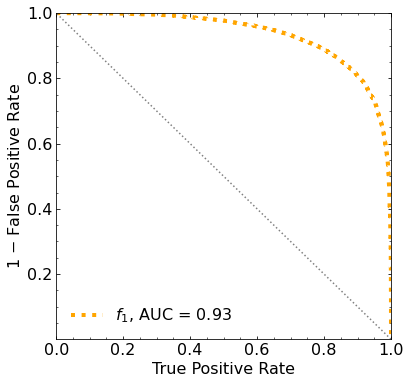

Classification score:


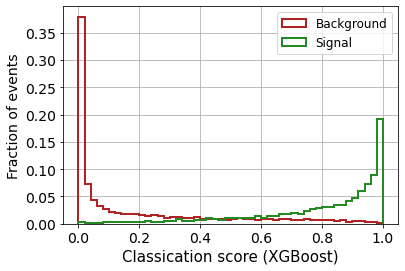


 ROC-AUC =  0.934207939310441


In [23]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

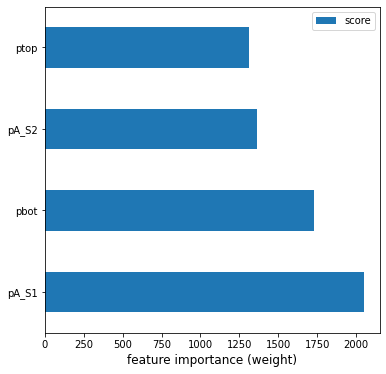

In [24]:
feature_important = classifier.get_booster().get_score(importance_type='weight')
# keys = list(feature_important.keys())
keys = ['pA_S1','pA_S2','pbot', 'ptop']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Epoch 106/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4805 - accuracy: 0.7709 - val_loss: 0.4913 - val_accuracy: 0.7704
Epoch 107/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4837 - accuracy: 0.7717 - val_loss: 0.4477 - val_accuracy: 0.8096
Epoch 108/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4846 - accuracy: 0.7677 - val_loss: 0.4081 - val_accuracy: 0.8348
Epoch 109/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4844 - accuracy: 0.7713 - val_loss: 0.4481 - val_accuracy: 0.8089
Epoch 110/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.7712 - val_loss: 0.4462 - val_accuracy: 0.8100
Epoch 111/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4821 - accuracy: 0.7697 - val_loss: 0.4477 - val_accuracy: 0.8073
Epoch 112/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4868 - accuracy: 0.7680 - val_loss: 0.4025 - val_ac

319/319 [==============================] - 1s 2ms/step - loss: 0.4744 - accuracy: 0.7770 - val_loss: 0.4683 - val_accuracy: 0.7854
Epoch 219/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4699 - accuracy: 0.7810 - val_loss: 0.4136 - val_accuracy: 0.8343
Epoch 220/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4729 - accuracy: 0.7773 - val_loss: 0.4119 - val_accuracy: 0.8312
Epoch 221/500
319/319 [==============================] - 1s 2ms/step - loss: 0.4666 - accuracy: 0.7849 - val_loss: 0.4177 - val_accuracy: 0.8283
Restoring model weights from the end of the best epoch.
Epoch 00221: early stopping


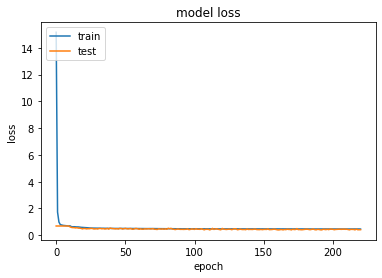

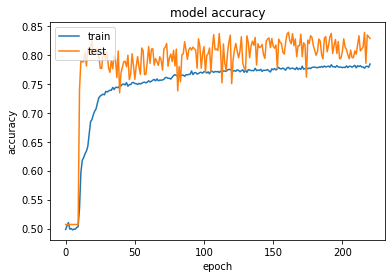

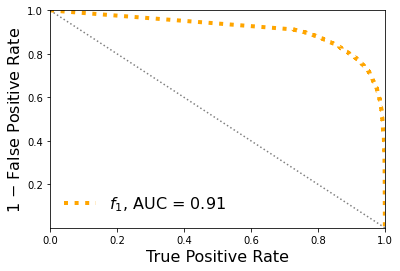

Classification score:


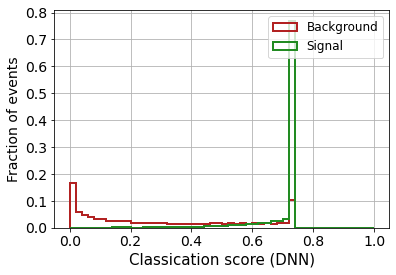


 ROC-AUC =  0.9132733933211132


In [25]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [73]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
122/122 [==============================] - 0s 2ms/step - loss: 6.0398 - accuracy: 0.5416 - val_loss: 0.6297 - val_accuracy: 0.5144
Epoch 2/500
122/122 [==============================] - 0s 1ms/step - loss: 0.6210 - accuracy: 0.5474 - val_loss: 0.6145 - val_accuracy: 0.5467
Epoch 3/500
122/122 [==============================] - 0s 1ms/step - loss: 0.6140 - accuracy: 0.5790 - val_loss: 0.6051 - val_accuracy: 0.7157
Epoch 4/500
122/122 [==============================] - 0s 1ms/step - loss: 0.6079 - accuracy: 0.6046 - val_loss: 0.5816 - val_accuracy: 0.6332
Epoch 5/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5995 - accuracy: 0.6260 - val_loss: 0.5692 - val_accuracy: 0.7354
Epoch 6/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5932 - accuracy: 0.6510 - val_loss: 0.5676 - val_accuracy: 0.7684
Epoch 7/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5872 - accuracy: 0.6733 - val_loss: 0.5510 - val_accuracy: 0.7568

Epoch 58/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5086 - accuracy: 0.7598 - val_loss: 0.4450 - val_accuracy: 0.8084
Epoch 59/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5035 - accuracy: 0.7646 - val_loss: 0.4368 - val_accuracy: 0.8168
Epoch 60/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5015 - accuracy: 0.7641 - val_loss: 0.4541 - val_accuracy: 0.8037
Epoch 61/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5039 - accuracy: 0.7631 - val_loss: 0.4550 - val_accuracy: 0.8015
Epoch 62/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4975 - accuracy: 0.7645 - val_loss: 0.4386 - val_accuracy: 0.8157
Epoch 63/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5010 - accuracy: 0.7619 - val_loss: 0.4338 - val_accuracy: 0.8179
Epoch 64/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5058 - accuracy: 0.7598 - val_loss: 0.4337 - val_accuracy:

Epoch 115/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4961 - accuracy: 0.7667 - val_loss: 0.4464 - val_accuracy: 0.8113
Epoch 116/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4976 - accuracy: 0.7679 - val_loss: 0.4370 - val_accuracy: 0.8172
Epoch 117/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5016 - accuracy: 0.7624 - val_loss: 0.4278 - val_accuracy: 0.8204
Epoch 118/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5153 - accuracy: 0.7561 - val_loss: 0.4347 - val_accuracy: 0.8193
Epoch 119/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4985 - accuracy: 0.7644 - val_loss: 0.4271 - val_accuracy: 0.8241
Epoch 120/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4958 - accuracy: 0.7694 - val_loss: 0.4267 - val_accuracy: 0.8230
Epoch 121/500
122/122 [==============================] - 0s 1ms/step - loss: 0.5052 - accuracy: 0.7615 - val_loss: 0.4475 - val_ac

122/122 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.7670 - val_loss: 0.4258 - val_accuracy: 0.8164
Epoch 228/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7738 - val_loss: 0.4192 - val_accuracy: 0.8292
Epoch 229/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.7788 - val_loss: 0.4319 - val_accuracy: 0.8237
Epoch 230/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.7722 - val_loss: 0.4304 - val_accuracy: 0.8241
Epoch 231/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4897 - accuracy: 0.7733 - val_loss: 0.4174 - val_accuracy: 0.8313
Epoch 232/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4849 - accuracy: 0.7735 - val_loss: 0.4502 - val_accuracy: 0.8110
Epoch 233/500
122/122 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7699 - val_loss: 0.4640 - val_accuracy: 0.8001

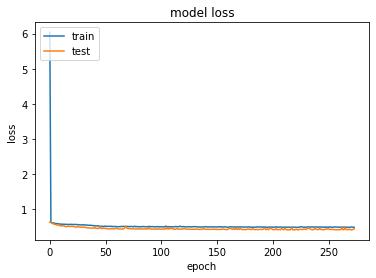

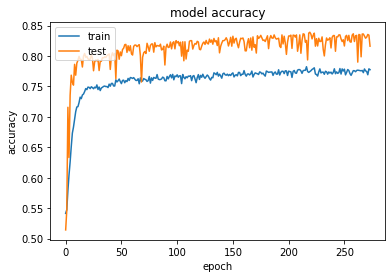

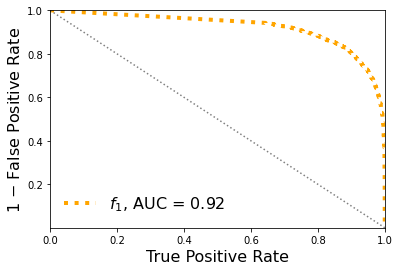

Classification score:


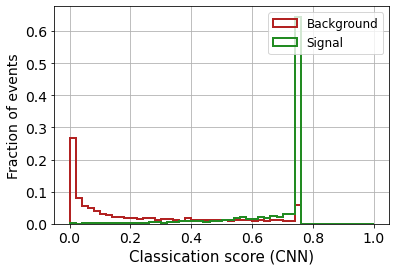


 ROC-AUC =  0.9219638047894911


In [76]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

### Keep only diffT

In [14]:
# concatenate the data
# X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
# X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 1)
X_mon_S.shape:  (32015, 1)
X_mon.shape:  (64030, 1)

X_mon_train :  (40818, 1)
y_mon_train :  (40818,)
X_mon_val :  (7204, 1)
y_mon_val :  (7204,)
X_mon_test :  (16008, 1)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.69276	validation_1-logloss:0.69300
[1]	validation_0-logloss:0.69239	validation_1-logloss:0.69293
[2]	validation_0-logloss:0.69207	validation_1-logloss:0.69291
[3]	validation_0-logloss:0.69177	validation_1-logloss:0.69293


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.69153	validation_1-logloss:0.69292
[5]	validation_0-logloss:0.69129	validation_1-logloss:0.69294
[6]	validation_0-logloss:0.69109	validation_1-logloss:0.69302
[7]	validation_0-logloss:0.69087	validation_1-logloss:0.69310
[8]	validation_0-logloss:0.69071	validation_1-logloss:0.69320
[9]	validation_0-logloss:0.69048	validation_1-logloss:0.69326
[10]	validation_0-logloss:0.69028	validation_1-logloss:0.69332
[11]	validation_0-logloss:0.69015	validation_1-logloss:0.69329
[12]	validation_0-logloss:0.68996	validation_1-logloss:0.69338
[13]	validation_0-logloss:0.68979	validation_1-logloss:0.69351
[14]	validation_0-logloss:0.68965	validation_1-logloss:0.69354
[15]	validation_0-logloss:0.68952	validation_1-logloss:0.69360
[16]	validation_0-logloss:0.68933	validation_1-logloss:0.69368
[17]	validation_0-logloss:0.68910	validation_1-logloss:0.69380
[18]	validation_0-logloss:0.68902	validation_1-logloss:0.69380
[19]	validation_0-logloss:0.68890	validation_1-logloss:0.6938

[134]	validation_0-logloss:0.67800	validation_1-logloss:0.69686
[135]	validation_0-logloss:0.67792	validation_1-logloss:0.69686
[136]	validation_0-logloss:0.67789	validation_1-logloss:0.69688
[137]	validation_0-logloss:0.67780	validation_1-logloss:0.69688
[138]	validation_0-logloss:0.67775	validation_1-logloss:0.69690
[139]	validation_0-logloss:0.67773	validation_1-logloss:0.69695
[140]	validation_0-logloss:0.67771	validation_1-logloss:0.69696
[141]	validation_0-logloss:0.67769	validation_1-logloss:0.69696
[142]	validation_0-logloss:0.67762	validation_1-logloss:0.69695
[143]	validation_0-logloss:0.67753	validation_1-logloss:0.69690
[144]	validation_0-logloss:0.67752	validation_1-logloss:0.69693
[145]	validation_0-logloss:0.67738	validation_1-logloss:0.69700
[146]	validation_0-logloss:0.67725	validation_1-logloss:0.69697
[147]	validation_0-logloss:0.67724	validation_1-logloss:0.69698
[148]	validation_0-logloss:0.67720	validation_1-logloss:0.69702
[149]	validation_0-logloss:0.67707	valid

[263]	validation_0-logloss:0.66936	validation_1-logloss:0.69884
[264]	validation_0-logloss:0.66934	validation_1-logloss:0.69885
[265]	validation_0-logloss:0.66929	validation_1-logloss:0.69884
[266]	validation_0-logloss:0.66920	validation_1-logloss:0.69896
[267]	validation_0-logloss:0.66904	validation_1-logloss:0.69900
[268]	validation_0-logloss:0.66899	validation_1-logloss:0.69903
[269]	validation_0-logloss:0.66891	validation_1-logloss:0.69901
[270]	validation_0-logloss:0.66890	validation_1-logloss:0.69901
[271]	validation_0-logloss:0.66890	validation_1-logloss:0.69901
[272]	validation_0-logloss:0.66876	validation_1-logloss:0.69903
[273]	validation_0-logloss:0.66869	validation_1-logloss:0.69915
[274]	validation_0-logloss:0.66861	validation_1-logloss:0.69919
[275]	validation_0-logloss:0.66855	validation_1-logloss:0.69924
[276]	validation_0-logloss:0.66846	validation_1-logloss:0.69923
[277]	validation_0-logloss:0.66843	validation_1-logloss:0.69924
[278]	validation_0-logloss:0.66837	valid

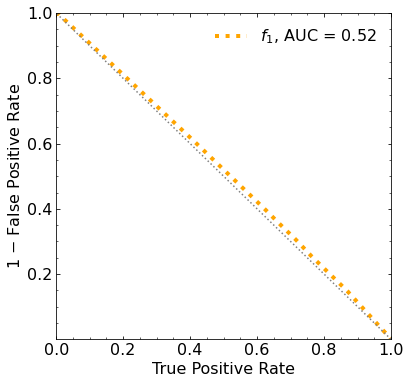

Classification score:


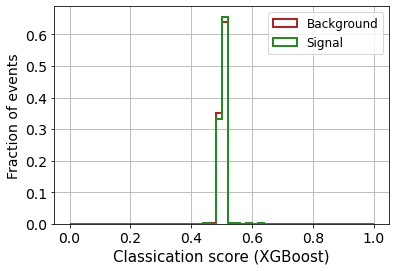


 ROC-AUC =  0.5150366577158461


In [12]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=300,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

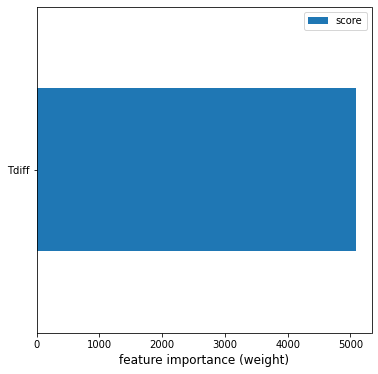

In [13]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['Tdiff']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

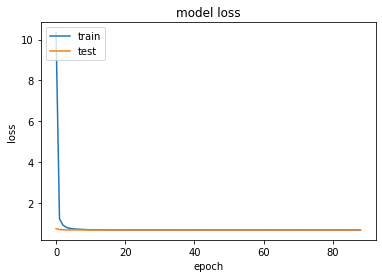

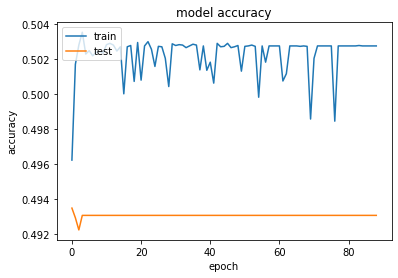

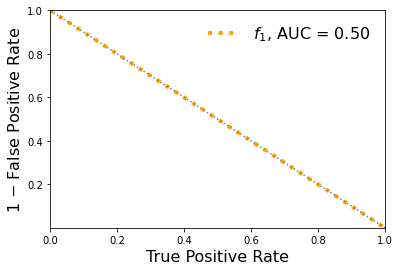

Classification score:


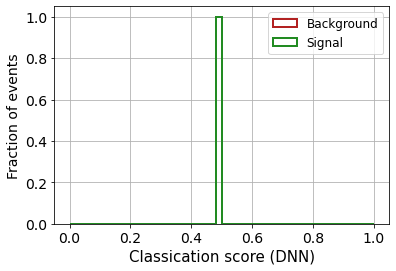


 ROC-AUC =  0.5


In [14]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [15]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [16]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node conv1d_1/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_1/conv1d/ExpandDims, conv1d_1/conv1d/ExpandDims_1)' with input shapes: [?,1,1,1], [1,2,1,8].

### Keep the 6 most important features

##### Remove some columns or features (if you want)

In [51]:
# features = ['pT0','pA','pH','pHT','pL','pL90','pRMSW','pHTL']
remove_col_S1 = [0,2,3,4,5,7]
remove_col_S2 = [0,2,3,4,5,6,7]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col_S1, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col_S2, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col_S1, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col_S2, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 2)
B_ppeakS2.shape:  (32015, 1)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 2)
S_ppeakS2.shape:  (32015, 1)


In [52]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 6)
X_mon_S.shape:  (32015, 6)
X_mon.shape:  (64030, 6)

X_mon_train :  (40818, 6)
y_mon_train :  (40818,)
X_mon_val :  (7204, 6)
y_mon_val :  (7204,)
X_mon_test :  (16008, 6)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.62914	validation_1-logloss:0.62988
[1]	validation_0-logloss:0.57610	validation_1-logloss:0.57705
[2]	validation_0-logloss:0.53104	validation_1-logloss:0.53283
[3]	validation_0-logloss:0.49231	validation_1-logloss:0.49445


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.45931	validation_1-logloss:0.46156
[5]	validation_0-logloss:0.43019	validation_1-logloss:0.43296
[6]	validation_0-logloss:0.40463	validation_1-logloss:0.40785
[7]	validation_0-logloss:0.38220	validation_1-logloss:0.38520
[8]	validation_0-logloss:0.36219	validation_1-logloss:0.36529
[9]	validation_0-logloss:0.34402	validation_1-logloss:0.34774
[10]	validation_0-logloss:0.32782	validation_1-logloss:0.33206
[11]	validation_0-logloss:0.31367	validation_1-logloss:0.31798
[12]	validation_0-logloss:0.30095	validation_1-logloss:0.30560
[13]	validation_0-logloss:0.28939	validation_1-logloss:0.29481
[14]	validation_0-logloss:0.27913	validation_1-logloss:0.28458
[15]	validation_0-logloss:0.27002	validation_1-logloss:0.27590
[16]	validation_0-logloss:0.26103	validation_1-logloss:0.26745
[17]	validation_0-logloss:0.25314	validation_1-logloss:0.25991
[18]	validation_0-logloss:0.24591	validation_1-logloss:0.25349
[19]	validation_0-logloss:0.23960	validation_1-logloss:0.2473

[134]	validation_0-logloss:0.14221	validation_1-logloss:0.17364
[135]	validation_0-logloss:0.14205	validation_1-logloss:0.17361
[136]	validation_0-logloss:0.14190	validation_1-logloss:0.17364
[137]	validation_0-logloss:0.14168	validation_1-logloss:0.17362
[138]	validation_0-logloss:0.14150	validation_1-logloss:0.17364
[139]	validation_0-logloss:0.14132	validation_1-logloss:0.17363
[140]	validation_0-logloss:0.14116	validation_1-logloss:0.17353
[141]	validation_0-logloss:0.14107	validation_1-logloss:0.17348
[142]	validation_0-logloss:0.14095	validation_1-logloss:0.17350
[143]	validation_0-logloss:0.14080	validation_1-logloss:0.17341
[144]	validation_0-logloss:0.14058	validation_1-logloss:0.17349
[145]	validation_0-logloss:0.14040	validation_1-logloss:0.17349
[146]	validation_0-logloss:0.14020	validation_1-logloss:0.17343
[147]	validation_0-logloss:0.14005	validation_1-logloss:0.17351
[148]	validation_0-logloss:0.13994	validation_1-logloss:0.17349
[149]	validation_0-logloss:0.13985	valid

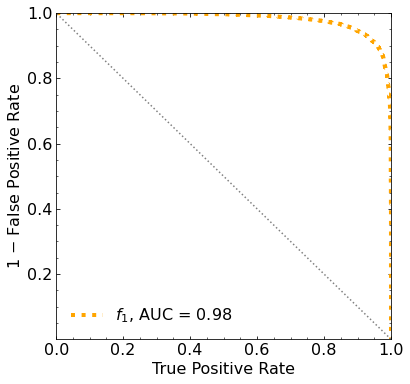

Classification score:


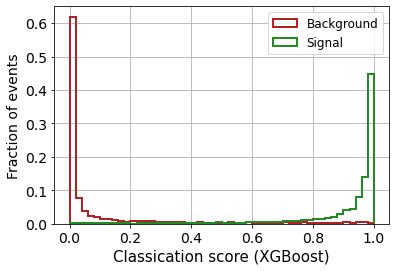


 ROC-AUC =  0.9812101917440055


In [53]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

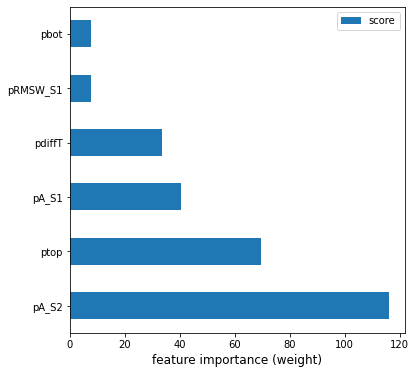

In [54]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['pA_S1','pRMSW_S1', 'pA_S2','pbot', 'ptop', 'pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 28        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

319/319 [==============================] - 0s 572us/step - loss: 0.3797 - accuracy: 0.8223 - val_loss: 0.3041 - val_accuracy: 0.8784
Epoch 105/500
319/319 [==============================] - 0s 558us/step - loss: 0.3819 - accuracy: 0.8251 - val_loss: 0.5172 - val_accuracy: 0.8111
Epoch 106/500
319/319 [==============================] - 0s 572us/step - loss: 0.3836 - accuracy: 0.8274 - val_loss: 0.4447 - val_accuracy: 0.8305
Epoch 107/500
319/319 [==============================] - 0s 561us/step - loss: 0.3793 - accuracy: 0.8231 - val_loss: 0.3370 - val_accuracy: 0.8717
Epoch 108/500
319/319 [==============================] - 0s 584us/step - loss: 0.3683 - accuracy: 0.8317 - val_loss: 0.3468 - val_accuracy: 0.8624
Epoch 109/500
319/319 [==============================] - 0s 535us/step - loss: 0.3678 - accuracy: 0.8301 - val_loss: 0.4588 - val_accuracy: 0.8286
Epoch 110/500
319/319 [==============================] - 0s 532us/step - loss: 0.3751 - accuracy: 0.8239 - val_loss: 0.3464 - val_ac

Epoch 160/500
319/319 [==============================] - 0s 537us/step - loss: 0.3755 - accuracy: 0.8251 - val_loss: 0.3689 - val_accuracy: 0.8517
Epoch 161/500
319/319 [==============================] - 0s 537us/step - loss: 0.3755 - accuracy: 0.8239 - val_loss: 0.3713 - val_accuracy: 0.8530
Epoch 162/500
319/319 [==============================] - 0s 548us/step - loss: 0.3608 - accuracy: 0.8300 - val_loss: 0.4083 - val_accuracy: 0.8474
Epoch 163/500
319/319 [==============================] - 0s 540us/step - loss: 0.3730 - accuracy: 0.8272 - val_loss: 0.4198 - val_accuracy: 0.8502
Epoch 164/500
319/319 [==============================] - 0s 553us/step - loss: 0.3680 - accuracy: 0.8269 - val_loss: 0.4399 - val_accuracy: 0.8327
Epoch 165/500
319/319 [==============================] - 0s 555us/step - loss: 0.3660 - accuracy: 0.8322 - val_loss: 0.4878 - val_accuracy: 0.8096
Epoch 166/500
319/319 [==============================] - 0s 552us/step - loss: 0.3677 - accuracy: 0.8284 - val_loss: 0

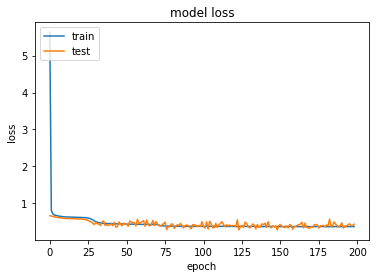

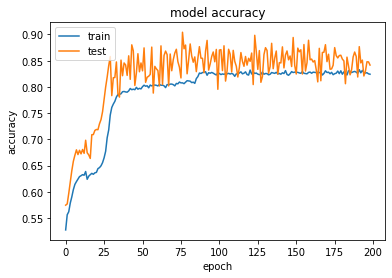

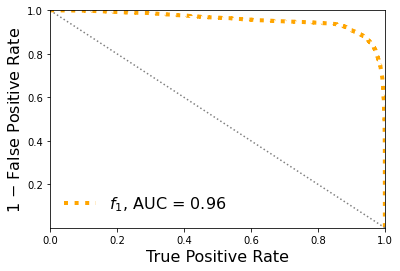

Classification score:


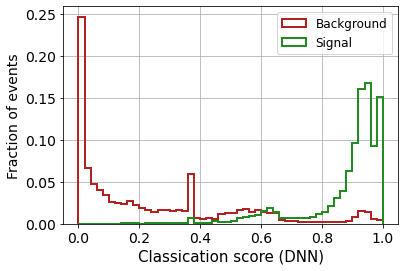


 ROC-AUC =  0.9561881214355025


In [55]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [56]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 2s 1ms/step - loss: 9.0543 - accuracy: 0.4836 - val_loss: 0.7367 - val_accuracy: 0.5021
Epoch 2/500
319/319 [==============================] - 0s 608us/step - loss: 0.7654 - accuracy: 0.4914 - val_loss: 0.7194 - val_accuracy: 0.5043
Epoch 3/500
319/319 [==============================] - 0s 619us/step - loss: 0.7482 - accuracy: 0.4910 - val_loss: 0.7117 - val_accuracy: 0.4931
Epoch 4/500
319/319 [==============================] - 0s 614us/step - loss: 0.7080 - accuracy: 0.5054 - val_loss: 0.7081 - val_accuracy: 0.4931
Epoch 5/500
319/319 [==============================] - 0s 654us/step - loss: 0.7129 - accuracy: 0.5050 - val_loss: 0.7062 - val_accuracy: 0.4931
Epoch 6/500
319/319 [==============================] - 0s 624us/step - loss: 0.7184 - accuracy: 0.5020 - val_loss: 0.7049 - val_accuracy: 0.4931
Epoch 7/500
319/319 [==============================] - 0s 637us/step - loss: 0.7112 - accuracy: 0.4988 - val_loss: 0.7039 - val_accu

319/319 [==============================] - 0s 613us/step - loss: 0.4230 - accuracy: 0.8245 - val_loss: 0.3368 - val_accuracy: 0.8906
Epoch 114/500
319/319 [==============================] - 0s 618us/step - loss: 0.4322 - accuracy: 0.8187 - val_loss: 0.3183 - val_accuracy: 0.9084
Epoch 115/500
319/319 [==============================] - 0s 616us/step - loss: 0.4298 - accuracy: 0.8225 - val_loss: 0.3119 - val_accuracy: 0.9138
Epoch 116/500
319/319 [==============================] - 0s 626us/step - loss: 0.4361 - accuracy: 0.8149 - val_loss: 0.3211 - val_accuracy: 0.9100
Epoch 117/500
319/319 [==============================] - 0s 612us/step - loss: 0.4387 - accuracy: 0.8154 - val_loss: 0.3210 - val_accuracy: 0.9070
Epoch 118/500
319/319 [==============================] - 0s 608us/step - loss: 0.4321 - accuracy: 0.8200 - val_loss: 0.3148 - val_accuracy: 0.9123
Epoch 119/500
319/319 [==============================] - 0s 594us/step - loss: 0.4390 - accuracy: 0.8149 - val_loss: 0.3150 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 626us/step - loss: 0.4256 - accuracy: 0.8247 - val_loss: 0.3215 - val_accuracy: 0.9006
Epoch 170/500
319/319 [==============================] - 0s 616us/step - loss: 0.4336 - accuracy: 0.8188 - val_loss: 0.3106 - val_accuracy: 0.9146
Epoch 171/500
319/319 [==============================] - 0s 617us/step - loss: 0.4284 - accuracy: 0.8229 - val_loss: 0.3281 - val_accuracy: 0.8976
Epoch 172/500
319/319 [==============================] - 0s 613us/step - loss: 0.4237 - accuracy: 0.8261 - val_loss: 0.3094 - val_accuracy: 0.9164
Epoch 173/500
319/319 [==============================] - 0s 616us/step - loss: 0.4274 - accuracy: 0.8216 - val_loss: 0.3149 - val_accuracy: 0.9137
Epoch 174/500
319/319 [==============================] - 0s 619us/step - loss: 0.4324 - accuracy: 0.8196 - val_loss: 0.3176 - val_accuracy: 0.9096
Epoch 175/500
319/319 [==============================] - 0s 627us/step - loss: 0.4301 - accuracy: 0.8213 - val_loss: 0

Epoch 225/500
319/319 [==============================] - 0s 603us/step - loss: 0.4164 - accuracy: 0.8259 - val_loss: 0.3202 - val_accuracy: 0.8970
Epoch 226/500
319/319 [==============================] - 0s 601us/step - loss: 0.4174 - accuracy: 0.8273 - val_loss: 0.3146 - val_accuracy: 0.8983
Epoch 227/500
319/319 [==============================] - 0s 640us/step - loss: 0.4161 - accuracy: 0.8267 - val_loss: 0.3321 - val_accuracy: 0.8891
Epoch 228/500
319/319 [==============================] - 0s 641us/step - loss: 0.4127 - accuracy: 0.8290 - val_loss: 0.3166 - val_accuracy: 0.8977
Epoch 229/500
319/319 [==============================] - 0s 614us/step - loss: 0.4162 - accuracy: 0.8272 - val_loss: 0.3001 - val_accuracy: 0.9095
Epoch 230/500
319/319 [==============================] - 0s 622us/step - loss: 0.4187 - accuracy: 0.8250 - val_loss: 0.2994 - val_accuracy: 0.9078
Epoch 231/500
319/319 [==============================] - 0s 586us/step - loss: 0.4152 - accuracy: 0.8266 - val_loss: 0

Epoch 281/500
319/319 [==============================] - 0s 598us/step - loss: 0.4162 - accuracy: 0.8260 - val_loss: 0.3096 - val_accuracy: 0.9019
Restoring model weights from the end of the best epoch.
Epoch 00281: early stopping


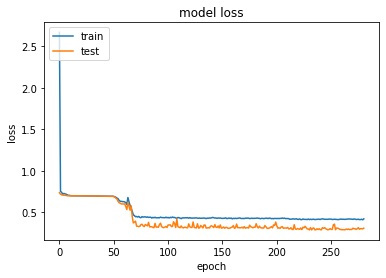

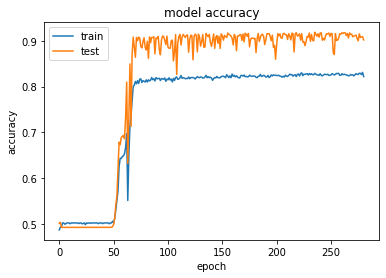

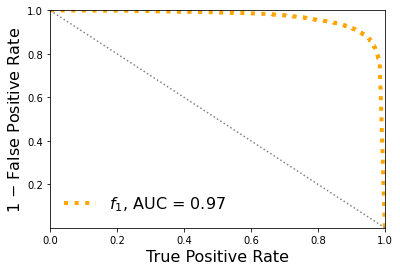

Classification score:


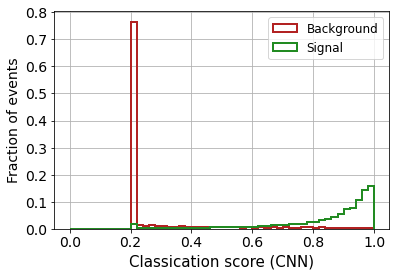


 ROC-AUC =  0.9658440072639971


In [57]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)